# 注意力分数为何要除于$\sqrt{d}$

In [2]:
import torch
import math
import torch.nn.functional as F
torch.manual_seed(0)

## 创建数据

In [3]:
d = 1024
n = 100

In [4]:
q = torch.randn(1, d)
k = torch.randn(1, d)
Q = torch.randn(n, d)
K = torch.randn(n, d)

In [5]:
# 数据都为独立变量，服从方差为1，均值为0的正态分布

print(q.mean(), q.var())
print(k.mean(), k.var())
print(Q.mean(), Q.var())
print(K.mean(), K.var())

tensor(0.0322) tensor(1.0567)

tensor(-0.0057) tensor(1.0215)

tensor(-0.0028) tensor(1.0012)

tensor(-0.0047) tensor(0.9994)

## 单独向量计算注意力分数

除于sqrt d 的数据接近1，而除于d的数据离1远的多

In [6]:
score = q @ k.t()
print(score)

score_d = q @ k.t() / d
print(score_d)

score_sqrt_d = q @ k.t() / math.sqrt(d)
print(score_sqrt_d)

tensor([[-19.6923]])

tensor([[-0.0192]])

tensor([[-0.6154]])

## 注意力分数与Softmax

我们注意到，注意力分数除于$\sqrt{d}$的数据分布符合正态分布

In [9]:
score_qK = q @ K.t()
score_qK_d = q @ K.t() / d
score_qK_sqrt_d = q @ K.t() / math.sqrt(d)

print(score_qK.shape)

print(score_qK.mean(), score_qK.var())
print(score_qK_d.mean(), score_qK_d.var())
print(score_qK_sqrt_d.mean(), score_qK_sqrt_d.var())

# compare scaled with d and sqrt d
print(score_qK_d[0,:10])
print(score_qK_sqrt_d[0,:10])

torch.Size([1, 100])

tensor(0.1173) tensor(960.1985)

tensor(0.0001) tensor(0.0009)

tensor(0.0037) tensor(0.9377)

tensor([-0.0244,  0.0074, -0.0200,  0.0068, -0.0271, -0.0447,  0.0573, -0.0701,
        -0.0133, -0.0341])

tensor([-0.7821,  0.2366, -0.6414,  0.2186, -0.8680, -1.4293,  1.8325, -2.2419,
        -0.4264, -1.0911])

### softmax前向计算

In [72]:
score_qK_softmax = F.softmax(score_qK, dim = 1)
score_qK_d_softmax = F.softmax(score_qK_d, dim = 1)
score_qK_sqrt_d_softmax = F.softmax(score_qK_sqrt_d, dim = 1)

print(score_qK_softmax.mean(), score_qK_softmax.var())
print(score_qK_d_softmax.mean(), score_qK_d_softmax.var()) # 方差太小，梯度小
print(score_qK_sqrt_d_softmax.mean(), score_qK_sqrt_d_softmax.var())

tensor(0.0100) tensor(0.0067)

tensor(0.0100) tensor(9.1749e-08)

tensor(0.0100) tensor(0.0001)

## 如果不除于$\sqrt{d}$ ， 那么Softmax的梯度会消失

Softmax的梯度如何计算？

In [28]:
d = 512
n = 100
q = torch.randn(1,d) 
K = torch.randn(n,d) 

# 不除于d的话， 这个梯度消失了
s = q@K.t() / math.sqrt(1)
s = F.softmax(s, dim=1)
ds = torch.diag(s[0])-s.t()@s
print(ds[0,:10])


# scaled d 这个梯度正常
s = q@K.t() / d
s = F.softmax(s, dim=1)
ds = torch.diag(s[0])-s.t()@s
print(ds[0,:10])


# scaled sqrt d 这个梯度正常
s = q@K.t() / math.sqrt(d)
s = F.softmax(s, dim=1)
ds = torch.diag(s[0])-s.t()@s
print(ds[0,:10])

tensor([ 1.2886e-17, -7.7264e-28,  0.0000e+00, -6.4039e-43,  0.0000e+00,
        -3.8536e-42,  0.0000e+00, -3.9298e-23,  0.0000e+00, -4.3368e-36])

tensor([ 1.0211e-02, -1.0970e-04, -1.0063e-04, -1.0250e-04, -1.0099e-04,
        -1.0286e-04, -9.8956e-05, -1.1204e-04, -9.9189e-05, -1.0570e-04])

tensor([ 1.1918e-02, -2.8683e-04, -4.0737e-05, -6.1818e-05, -4.4167e-05,
        -6.6921e-05, -2.7861e-05, -4.6305e-04, -2.9381e-05, -1.2388e-04])

## 为什么要除于根号d而不是直接除于d

如果这里的d=1000，即是1000维度。

如果直接除于d，那么softmax之后的分布与原分布差异太大
除于sqrt(d), softmax之后的分布与原数据接近

In [15]:
a = torch.tensor([1000.0, -2.0, 0.00001, 300.0])
F.softmax(a, dim = 0)

tensor([1., 0., 0., 0.])

In [16]:
print(F.softmax(a / math.sqrt(1000.0), dim = 0))
print(F.softmax(a / math.sqrt(1000.0), dim = 0).var())

tensor([1.0000e+00, 1.7335e-14, 1.8467e-14, 2.4349e-10])

tensor(0.2500)

In [17]:
print(F.softmax(a / 1000.0, dim = 0))
print(F.softmax(a / 1000.0, dim = 0).var())

tensor([0.4481, 0.1645, 0.1648, 0.2225])

tensor(0.0182)

## 为什么除于sqrt d后数据就是标准正态分布了

scale with sqrt d的目的在于，将数据进行归一化，使得数据服从标准正态分布，即是方差为1，均值为0

假定 X和Y是独立的随机变量，服从正态分布，那么

$$
\begin{align}
\mathbb{E}[X + Y] &= \mathbb{E}[X] + \mathbb{E}[Y] \\
Var(X + Y) &= Var(X) + Var(Y) \\
\mathbb{E}[XY] &= \mathbb{E}[X]\mathbb{E}[Y] \\
Var(XY) &= (Var(X) + \mathbb{E}[X]^2)(Var(Y) + \mathbb{E}[Y]^2) - \mathbb{E}[X]^2\mathbb{E}[Y]^2
\end{align}
$$

给定$d$维度向量的$q$和$k$，

$$
\displaystyle qk= \sum_{i=0}^{d} q_{i} k_{i}
$$


那么计算在第i维度计算$q_i k_i$的均值和方差：

$$
\mathbb{E}[q_i k_i] = \mathbb{E}[q_i] \mathbb{E}[k_i] = 0 \\
$$
$$
Var(q_i k_i) = (Var(q_i) + \mathbb{E}[q_i]^2)(Var(k_i) + \mathbb{E}[k_i]^2) - \mathbb{E}[q_i]^2\mathbb{E}[k_i]^2 = 1
$$

此时我们对完整两个向量$qk$求均值和方差
$$
\mathbb{E} \left[\displaystyle \sum_{i=0}^{d} q_i k_i \right] = \displaystyle \sum_{i=0}^{d} \mathbb{E} \left[ q_i k_i  \right] = 0 
$$
$$
Var\left(\displaystyle \sum_{i=0}^{d} q_i k_i \right) = \displaystyle \sum_{i=0}^{d} Var\left( q_i k_i  \right) = d
$$

结论是qk内积后服从均值0和方差d的分布。

**如何将方差变换为1**

随机变量X与常数相乘后的方差为：

如果X的方差为d,系数c，那么cX变量得方差为多少？

我们知道方差有一个重要性质：对于任意常数 c 和随机变量 X，

Var(cX) = c²Var(X)

如果c = 1/sqrt(d)， 那么就可以求得

Var(cX) = 1/d * d = 1

此时我们如果对于qk除于 $\sqrt{d}$ 那么


$$
Var(qk/\sqrt{d}) = \frac{1}{\sqrt{d}^2} Var(qk) = \frac{d}{\sqrt{d}^2} = 1
$$

如果qk除于d那么


$$
Var(qk/d) = \frac{1}{d^2} Var(qk) = \frac{d}{d^2} = \frac{1}{d}
$$


## 为什么输入要服从标准的正态分布

一个输入数据分布是正态分布X~ (0, 1)，那么能更快更好的收敛。

一个输入数据服从X~(0, 5)

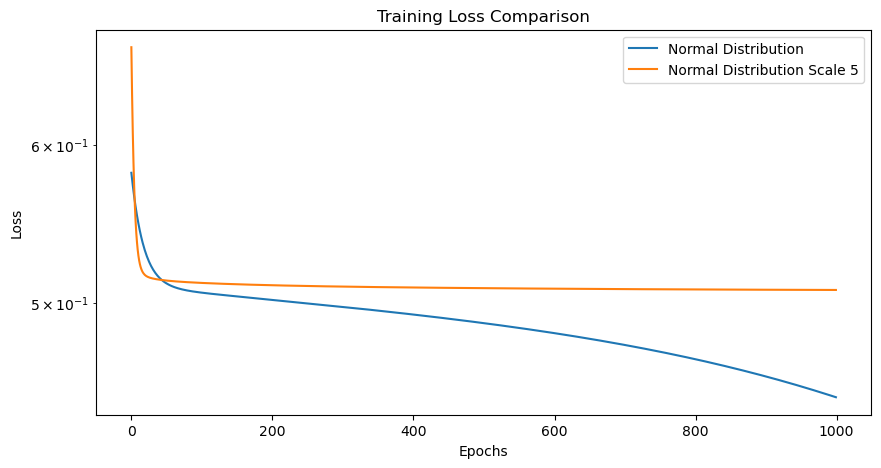

Final loss (Normal): 0.4484

Final loss (Normal 5): 0.5075

In [41]:
# 使用正态分布输入的模型收敛得更快。
# 正态分布输入的模型最终损失通常更低。
# 正态分布输入的训练过程更加稳定，损失曲线更平滑。

import copy
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 设置随机种子以保证可重复性
torch.manual_seed(42)

# 定义一个简单的神经网络
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 1)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

# 训练函数
def train_model(model, X, y, optimizer, criterion, epochs=1000):
    losses = []
    grad_norms = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        grad_norms.append(model.fc2.weight.grad.var())
        optimizer.step()
        losses.append(loss.item())
    return losses, grad_norms

# 生成数据
n_samples = 1000
X_normal = torch.randn(n_samples, 1)  # 正态分布
X_normal_scale = torch.randn(n_samples, 1) * 5  # 正态分布
# X_uniform = torch.rand(n_samples, 1) * 2 - 1  # 均匀分布 [-1, 1]


# 目标函数
y = torch.sin(X_normal * 3.14)

# 训练模型
model_normal = SimpleNet()
model_normal_scale = copy.deepcopy(model_normal)# 两个模型的权重一样

optimizer_normal = optim.SGD(model_normal.parameters(), lr=0.01)
optimizer_normal_scale = optim.SGD(model_normal_scale.parameters(), lr=0.01)

criterion = nn.MSELoss()

losses_normal, grad_norms_fc2_normal = train_model(model_normal, X_normal, y, optimizer_normal, criterion)
losses_normal_scale, grad_norms_fc2_uniform = train_model(model_normal_scale, X_normal_scale, y, optimizer_normal_scale, criterion)

# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(losses_normal, label='Normal Distribution')
plt.plot(losses_normal_scale, label='Normal Distribution Scale 5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.yscale('log')  # 使用对数刻度以更好地显示差异
plt.show()

# 打印最终损失, 方差为1的输入分布数据，拟合的loss更低。
print(f"Final loss (Normal): {losses_normal[-1]:.4f}")
print(f"Final loss (Normal 5): {losses_normal_scale[-1]:.4f}")